# Train Image Similarity

## Mount drive etc

In [ ]:
!nvidia-smi

## Run the Training Script

In [80]:
import torch
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.data import Dataset
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
%matplotlib inline
import os
import json    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [86]:
class FolderDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_folders = os.listdir(main_dir)
        self.all_imgs=[]
        for folder in self.all_folders:
            folder_dir=os.path.join(main_dir, folder)
            files=os.listdir(folder_dir)
            for file in files:
                self.all_imgs.append(os.path.join(folder_dir, file))
        with open("geological_map.json", 'w', encoding='utf-8') as f:
            json.dump(self.all_imgs, f)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = self.all_imgs[idx]
        image = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)
        # print(tensor_image.shape)
        return tensor_image, tensor_image


In [87]:

class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.img_size = img_size
        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        # print(x.shape)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # print(x.shape)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # print(x.shape)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # print(x.shape)
        return x


class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        # self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
#         self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
#         self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        # print(x.shape)
        x = self.deconv1(x)
        x = self.relu1(x)
        # print(x.shape)

        x = self.deconv2(x)
        x = self.relu2(x)
        # print(x.shape)

        x = self.deconv3(x)
        x = self.relu3(x)
        # print(x.shape)
        return x


In [88]:
IMG_PATH = "geological_similarity"
IMG_HEIGHT = 512  # The images are already resized here
IMG_WIDTH = 512  # The images are already resized here

SEED = 42
TRAIN_RATIO = 0.75
VAL_RATIO = 1 - TRAIN_RATIO
SHUFFLE_BUFFER_SIZE = 100

LEARNING_RATE = 1e-3
EPOCHS = 2
TRAIN_BATCH_SIZE = 32  # Let's see, I don't have GPU, Google Colab is best hope
TEST_BATCH_SIZE = 32  # Let's see, I don't have GPU, Google Colab is best hope
FULL_BATCH_SIZE = 32

AUTOENCODER_MODEL_PATH = "baseline_autoencoder.pt"
ENCODER_MODEL_PATH = "geological_encoding.pt"
DECODER_MODEL_PATH = "geological_decoding.pt"
EMBEDDING_SHAPE = (1, 64, 64, 64)
# TEST_RATIO = 0.2


In [89]:
"""
I can write this if we need custom training loop etc.
I usually use this in PyTorch.
"""

__all__ = ["train_step", "val_step", "create_embedding"]

import torch
import torch.nn as nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    # device = "cuda"
    encoder.train()
    decoder.train()

    # print(device)

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)
        loss = loss_fn(dec_output, target_img)
        loss.backward()

        optimizer.step()

    return loss.item()


def val_step(encoder, decoder, val_loader, loss_fn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            loss = loss_fn(dec_output, target_img)

    return loss.item()

In [90]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# print("Setting Seed for the run, seed = {}".format(config.SEED))

# seed_everything(config.SEED)

transforms = T.Compose([T.ToTensor(), T.CenterCrop(24)])
print("------------ Creating Dataset ------------")
full_dataset = FolderDataset(IMG_PATH, transforms)

train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

print("------------ Dataset Created ------------")
print("------------ Creating DataLoader ------------")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE
)

full_loader = torch.utils.data.DataLoader(
    full_dataset, batch_size=FULL_BATCH_SIZE
)
print(len(full_dataset.all_imgs))

------------ Creating Dataset ------------
------------ Dataset Created ------------
------------ Creating DataLoader ------------
29998


In [54]:
print("------------ Dataloader Cretead ------------")

# print(train_loader)
loss_fn = nn.MSELoss()

encoder = ConvEncoder()
decoder = ConvDecoder()

if torch.cuda.is_available():
    print("GPU Availaible moving models to GPU")
else:
    print("Moving models to CPU")

encoder.to(device)
decoder.to(device)

# print(device)

autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.AdamW(autoencoder_params, lr=LEARNING_RATE)

# early_stopper = utils.EarlyStopping(patience=5, verbose=True, path=)
max_loss = 9999

print("------------ Training started ------------")

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_step(
        encoder, decoder, train_loader, loss_fn, optimizer, device=device
    )
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    val_loss = val_step(
        encoder, decoder, val_loader, loss_fn, device=device
    )

    # Simple Best Model saving
    if val_loss < max_loss:
        print("Validation Loss decreased, saving new best model")
        torch.save(encoder.state_dict(), ENCODER_MODEL_PATH)
        torch.save(decoder.state_dict(), DECODER_MODEL_PATH)

    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

print("Training Done")

  0%|          | 0/2 [00:00<?, ?it/s]

------------ Dataloader Cretead ------------
Moving models to CPU
------------ Training started ------------
Epochs = 0, Training Loss : 0.007516584824770689


 50%|█████     | 1/2 [00:24<00:24, 24.73s/it]

Validation Loss decreased, saving new best model
Epochs = 0, Validation Loss : 0.004617605824023485
Epochs = 1, Training Loss : 0.00487650278955698


100%|██████████| 2/2 [00:48<00:00, 24.09s/it]

Validation Loss decreased, saving new best model
Epochs = 1, Validation Loss : 0.0026516627985984087
Training Done


In [55]:
embedding_dim = (32,64, 3, 3)

In [93]:
print(len(full_dataset.all_imgs))

29998


In [94]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    encoder.eval()
    embedding = None
    # print(embedding.shape)

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            print(enc_output.shape)
            if embedding==None:
                embedding=enc_output
            else:
                embedding = torch.cat((embedding, enc_output), 0)
            # print(embedding.shape)
    
    return embedding


In [95]:
embedding = create_embedding(encoder, full_loader, embedding_dim, device)

torch.Size([32, 64, 3, 3])


AttributeError: 'NoneType' object has no attribute 'shape'

In [58]:
print(embedding.shape)

torch.Size([30030, 64, 3, 3])


In [59]:
# embedding2 = embedding[4700:, :, :, ]

In [60]:
# print(embedding2.shape)

In [61]:
numpy_embedding = embedding.cpu().detach().numpy()

In [62]:
# numpy_embedding = embedding2.cpu().detach().numpy()

In [63]:
print(numpy_embedding.shape)

(30030, 64, 3, 3)


In [64]:
num_images = numpy_embedding.shape[0]
# print(num_images)

In [65]:
flattened_embedding = numpy_embedding.reshape((num_images, -1))

In [66]:
print(flattened_embedding.shape)

(30030, 576)


In [67]:
import numpy as np

In [68]:
np.save("geological_embed.npy", flattened_embedding)

In [22]:
# np.save("../input/animals-data/data_embedding.npy", flattened_embedding)

In [7]:
flattend_embedding_reloaded = np.load("data_embedding_f.npy")

In [8]:
encoder=ConvEncoder()
encoder.load_state_dict(torch.load('baseline_encoder.pt'))
decoder=ConvDecoder()
decoder.load_state_dict(torch.load('baseline_decoder.pt'))

<All keys matched successfully>

In [25]:

encoder.eval()
embedding = torch.randn(embedding_dim)
# print(embedding.shape)

with torch.no_grad():
    for batch_idx, (train_img, target_img) in enumerate(full_loader):
        train_img = train_img.to(device)
        #print(train_img==target_img)
        # print(train_img.shape)
        
        enc_output = encoder(train_img).cpu()
        dec_output= decoder(enc_output).cpu()
        # print(enc_output.shape)
        # print(target_img.shape)
        # print(dec_output.shape)

        output_ten=torch.flatten(dec_output[0])
        print(output_ten.shape)
        target_ten=torch.flatten(target_img[0])
        cos = nn.CosineSimilarity(dim=0, eps=1e-6)
        similarity = cos(output_ten,target_ten)
        print(similarity)
        print(type(similarity))
        trans=T.ToPILImage()
        break
        # embedding = torch.cat((embedding, enc_output), 0)
        # print(embedding.shape)


#         break


torch.Size([1728])
tensor(0.9979)
<class 'torch.Tensor'>


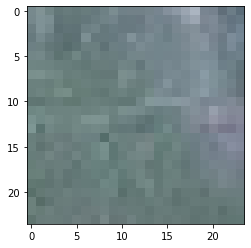

In [12]:
plt.imshow(trans(target_img[0]))


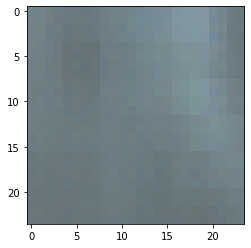

In [13]:
plt.imshow(trans(dec_output[0]))